# Import libraries

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
import os
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

# Get data 

In [141]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")

print(train_data.shape)
print(test_data.shape)

(891, 12)
(418, 11)


Helper functions for later visualization

In [142]:
def survived_bar_plot(feature):
    plt.figure(figsize = (6,4))
    sns.barplot(data = train_data , x = feature , y = "Survived").set_title(f"{feature} Vs Survived")
    plt.show()
def survived_hist_plot(feature):
    plt.figure(figsize = (6,4))
    sns.histplot(data = train_data , x = feature , hue = "Survived",binwidth=5,palette = sns.color_palette(["yellow" , "green"]) ,multiple = "stack" ).set_title(f"{feature} Vs Survived")
    plt.show()

Now I'm starting to notice that EDA (exploratory data analysis) is actually necessary, reasons:
- I don't know how to use this data in a ML model, I can't (as far as I know) give text as a feature, it should be a number, and I don't know what to do with Pclass, Name, Ticket, Cabin and Embarked. Sex I'll probably just turn into 0 and 1, and SibSp, Parch are fine I think.
- If there is incomplete data, I MUST to discover it, and handle it.

# Discovering null data

PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
dtype: float64


<AxesSubplot:>

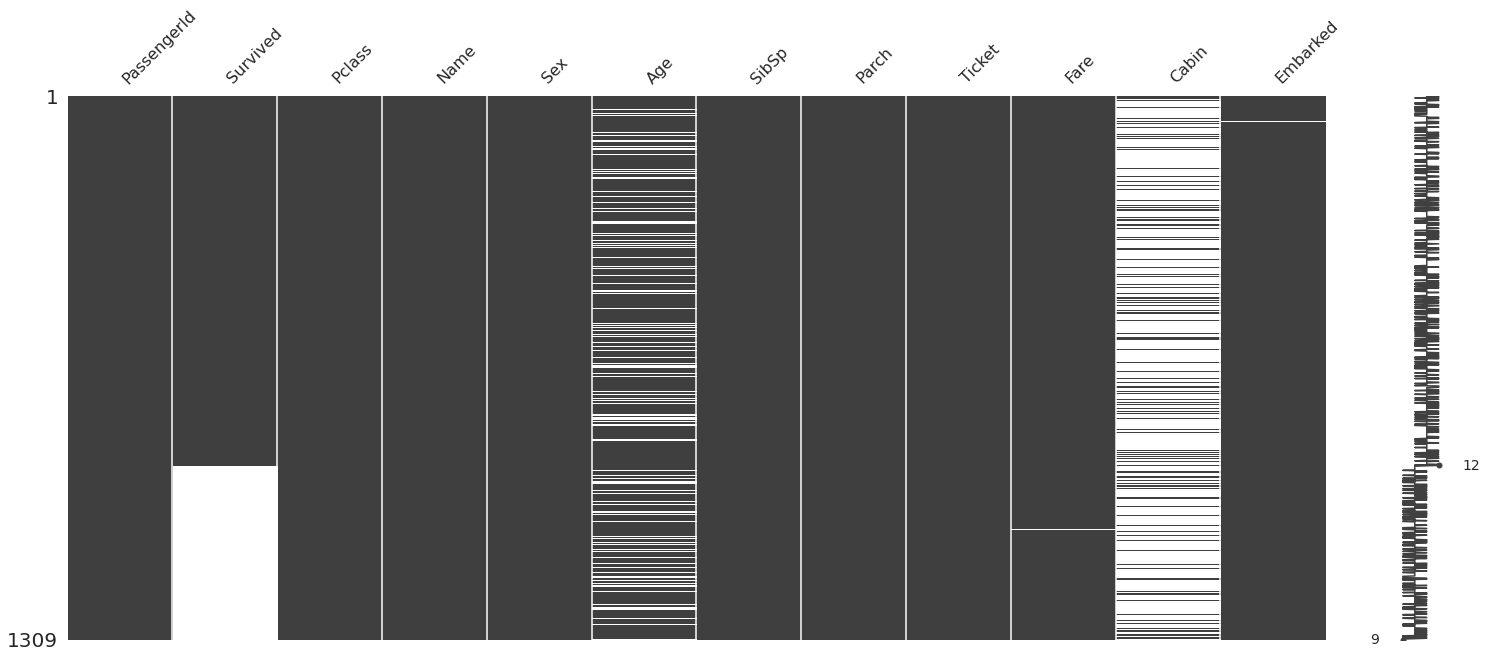

In [143]:
# merging train and test data into one big dataframe
test_data_with_survived_column = test_data.copy()
test_data_with_survived_column['Survived'] = None
all_data = pd.concat([train_data, test_data_with_survived_column])
print(all_data.isnull().mean()*100)

msno.matrix(all_data)

In [144]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    object 
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 132.9+ KB


# Handling Age and Fare null data

Here we can use imputing data techniques (mean, mode, time series, KNN, and MICE imputation): https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87

If we use techniques such as mean, mode or median, we'll fill data like in the image below, with all null data being given the same value (but we can do better):


<AxesSubplot:title={'center':'Mean Imputation'}, xlabel='Fare', ylabel='Age'>

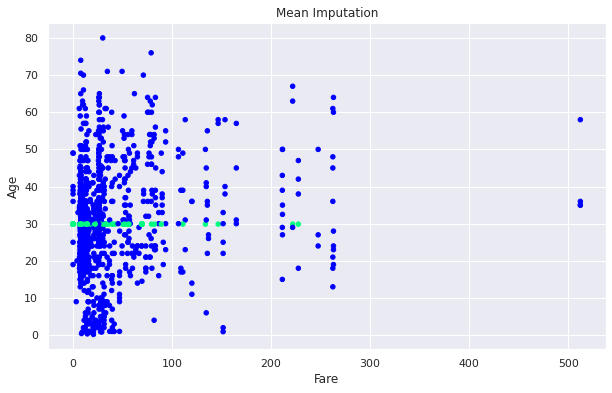

In [145]:
data_mean = all_data.copy()
mean_imputer = SimpleImputer(strategy='mean')
data_mean['Age'] = mean_imputer.fit_transform(data_mean['Age'].values.reshape(-1, 1))
null_values = all_data['Age'].isnull()
data_mean.plot(x='Fare', y='Age', kind='scatter', c=null_values, cmap='winter', title='Mean Imputation', colorbar=False)

However, take a look at the following plot, we can se that some features have significant correlation with age (such as SibSp, Pclass, and Parch), so we could use this information to try to predict the age of the person with better precision than just assigning a fixed age to everyone. I think this method already exists and is called MICE.

Or we can use another impute technique like KNN, shown next.

<AxesSubplot:>

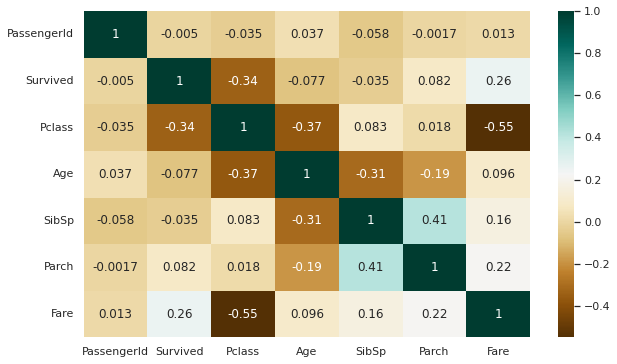

In [146]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(train_data.corr(), annot = True, fmt='.2g',cmap= 'BrBG')

KNN 2m video tutorial https://www.youtube.com/watch?v=0p0o5cmgLdE&ab_channel=IntuitiveMachineLearning

- KNN imputer uses multiple features, rather than using only one feature like in mean / mode / median imputers. 
- It works by looking for the closest k neighbors to each of the examples with missing values. Example: if we want to impute age, and n_neighbors=5, we'll look for the 5 people in our dataset with the smallest distance to it in other features. For that our features must be normalized (like between 0 and 1).
  - If someone has fare 0.1 and another has fare 0.6, their fare distance is 0.5
  - If someone has a class = "A" and another has class = "B", their "class" distance is 1 (if they were from the same class, their distance would be 0)
  - At the end we sum up all distances, and the k nearest neighbors are selected. If we want age, we just average theirs; but if we wanted to get a class, we would just assign to us the class that is most common between these k neighbors.

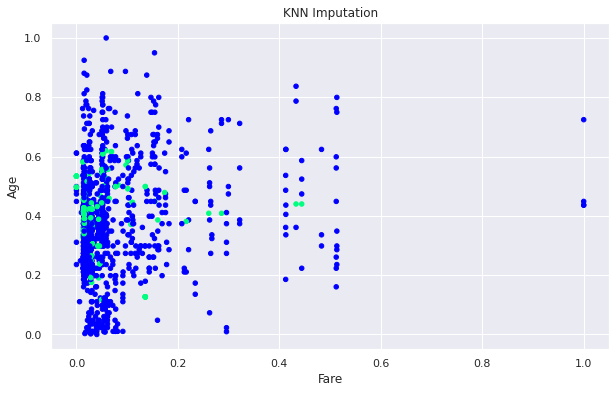

In [147]:
#Define a subset of the dataset (text features don't work with KNN)
data_knn = all_data.filter(['Fare','Age','SibSp','Parch', 'Pclass'], axis=1).copy()
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Define scaler to set values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_knn = pd.DataFrame(scaler.fit_transform(data_knn), columns = data_knn.columns)

# Define KNN imputer and fill missing values
tdx_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(data_knn), columns=data_knn.columns)
null_values = all_data['Age'].isnull()
tdx_knn_imputed.plot(x='Fare', y='Age', kind='scatter', c=null_values, cmap='winter', title='KNN Imputation', colorbar=False)

all_data['Age'] = tdx_knn_imputed['Age']
all_data['Fare'] = tdx_knn_imputed['Fare']

In [148]:
# Here we're taking a look at the types of the data, so we can choose which features we'll handle first.
# Numeric features are the easiest to handle (either continuous or discrete ones).
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    object 
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 132.9+ KB


Now that I imputed the "Age" feature, lets choose the next one to impute. I think Fare would be the easiest one, because it's numerical.

# Handling Cabin and Embarked null data

In [149]:
print("The number of Cabins is: ", len(all_data['Cabin'].unique()))
print(all_data['Cabin'].unique()[:20])

print("\nThe number of Embarked people is: ", len(all_data['Embarked'].unique()))
print(all_data['Embarked'].unique())

The number of Cabins is:  187
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12']

The number of Embarked people is:  4
['S' 'C' 'Q' nan]


S    914
C    270
Q    123
Name: Embarked, dtype: int64


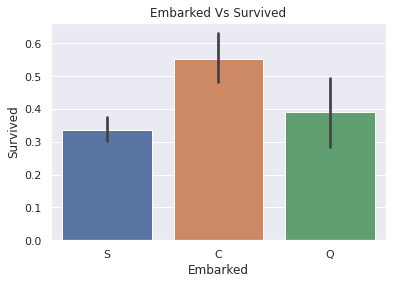

In [150]:
print(all_data['Embarked'].value_counts())
survived_bar_plot("Embarked")

# Since the majority of people have Embarked = S, I'll just assign S to the people with this feature missing

In [151]:
# I copy the all_data dataframe to avoid side effects (different outcomes when running cells multiple times)
all_data_processed = all_data.copy()
all_data_processed['Embarked'] = all_data['Embarked'].fillna('S')
# one hot encoding with pandas, instead of scikit-learn, just because it seemed easier
all_data_processed = pd.get_dummies(all_data, columns=['Embarked'])

# since the Cabin feature is missing in so many people, I'll just drop it, as well as other text features.
all_data_processed.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

# encode sex feature to binary
le = LabelEncoder()
all_data_processed['Sex'] = le.fit_transform(all_data['Sex'])
print(all_data_processed['Sex'].unique())

all_data_processed.info()

[1 0]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    object 
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   int64  
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1309 non-null   float64
 8   Embarked_C   1309 non-null   uint8  
 9   Embarked_Q   1309 non-null   uint8  
 10  Embarked_S   1309 non-null   uint8  
dtypes: float64(2), int64(5), object(1), uint8(3)
memory usage: 95.9+ KB


Split the data for training:

In [152]:
train_data_processed = all_data_processed[all_data_processed['Survived'].notnull()]
train_data_processed.drop(['PassengerId'], axis=1, inplace=True)
# X = train_data_processed[:, 1:]
# this ↑ won't work bc we can't slice a pandas dataframe with :
# iloc is what is really used (https://levelup.gitconnected.com/how-to-slice-a-dataframe-in-pandas-884bd8b298a6)
X = train_data_processed.iloc[:, 1:]
y = train_data_processed.iloc[:, 0].astype(int)

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2)

X_test = all_data_processed[all_data_processed['Survived'].isnull()]
test_ids = pd.Series(X_test.iloc[:, 0]) # get only the ids from the test data
X_test.drop(['Survived', 'PassengerId'], axis=1, inplace=True)

print(X.shape)
print(y.shape)
assert((X.columns == X_test.columns).all())

X_test.head()
y_train.info()

(891, 9)
(891,)
<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 787 to 418
Series name: Survived
Non-Null Count  Dtype
--------------  -----
712 non-null    int64
dtypes: int64(1)
memory usage: 11.1 KB


# Train the model

In [153]:
# Train the scikit-learn Logistic Regression model
clf = LogisticRegression(random_state=0,penalty='l2',max_iter=1000)
clf.fit(X_train, y_train)
  
print('Training accuracy =',clf.score(X_train, y_train))
y_train_prediction = clf.predict(X_train)
print(confusion_matrix(y_train, y_train_prediction))

print('Testing accuracy =',clf.score(X_cv, y_cv))
y_cv_prediction = clf.predict(X_cv)
print(confusion_matrix(y_cv, y_cv_prediction))

Training accuracy = 0.8103932584269663
[[381  60]
 [ 75 196]]
Testing accuracy = 0.7653631284916201
[[93 15]
 [27 44]]


In [154]:
y_test_prediction = pd.DataFrame(clf.predict(X_test), columns=['Survived'])
# don't forget the pd.Series, or you'll get a type error when concatenating

result=pd.concat([test_ids, y_test_prediction],axis=1)
result.to_csv('./solutions/kaggle_titanic.csv',index=False)